In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



Num_Points = 1


In [2]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Regression_2', Feature_Counts=[16,12])

#Reg_Data.df().head()

In [3]:
Reg_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6563692716200134


MLPRegressor(random_state=RandomState(MT19937) at 0x16666879840)

In [4]:
Reg_Data.Random_Forest()

0.6007039873954558


RandomForestRegressor(random_state=RandomState(MT19937) at 0x16666879840)

In [5]:
Reg_Data.GP()

-0.44136907250481183


GaussianProcessRegressor()

In [6]:
print(Reg_Data.get_features())

['Passive_0', 'Passive_1', 'Active_2', 'Active_3', 'Active_4', 'Active_5', 'Active_6', 'Active_7']


In [7]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Reg_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Reg_Data.get_features(),
                   categorical_features = Reg_Data.get_catagorical(),
                   mode                 = Reg_Data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [8]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [ 8.84932188  5.86067117  1.86580545  4.49675737  8.92051044  6.23877181
 10.70482584 10.79766589]
Std 0:  [4.92940767 4.21569994 1.44499629 3.42938069 4.71878826 4.45340708
 5.36245899 5.86793903]


In [9]:
# Generate explantion data for Random Forest

Reg_Stats = Feature_Statistics(feature_names = Reg_Data.get_features(), mode = Reg_Data.get_mode())

if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    normalize   = False)
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         model         = URM_Exp.get_exp_model())


INSTANCE:  0
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[76.80972216] [7.68097222e+01 1.00000004e-05] [76.80972218]


In [10]:
import matplotlib.pyplot as plt


In [11]:
print(f_predict)
print(e_predict)


[76.80972216]
[7.68097222e+01 1.00000004e-05]


In [12]:
Reg_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


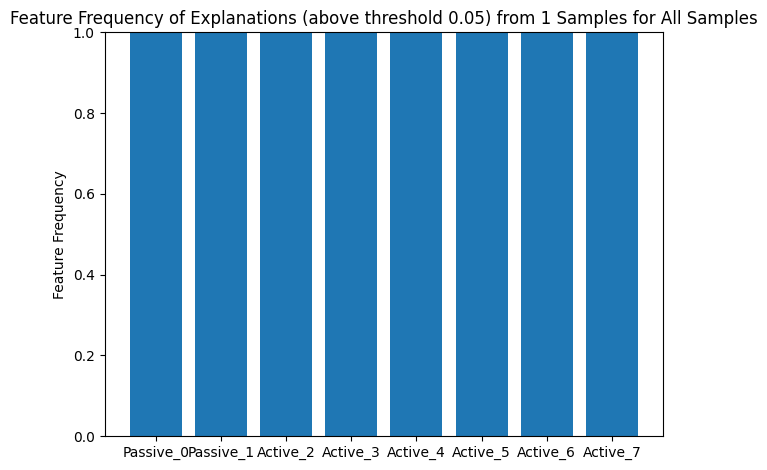

In [13]:
Reg_Stats.Frequency_Plot()


In [14]:
Reg_Stats.Fidelity()

Average, Var, and Max Differences:
y - BB(x):           62.23868240667946  :  0.0  :  62.23868240667946
y - exp(x):          62.238682371290224  :  0.0  :  62.238682371290224
BB(x) - exp(x):      3.538923465384869e-08  :  0.0  :  3.538923465384869e-08
Average exp(x) var:  1.0000000413701846e-05


In [15]:
Reg_Stats.Jaccard_Values()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Jaccard Similarity:  nan
Mean Jaccard Distance:    nan


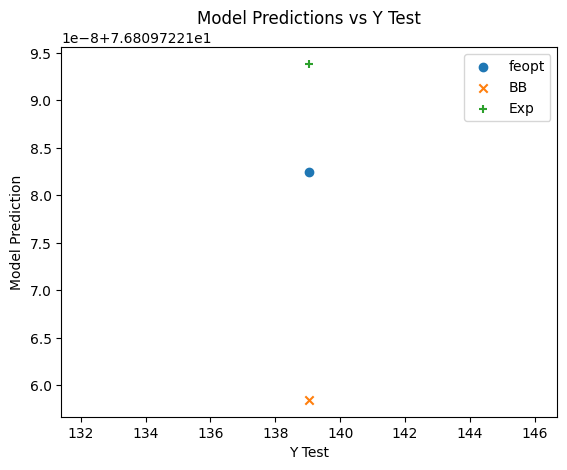

In [16]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (1, 8)


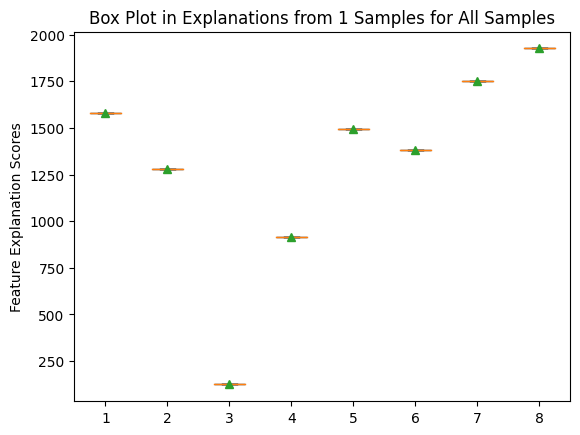

1 -      Passive_0
2 -      Passive_1
3 -      Active_2
4 -      Active_3
5 -      Active_4
6 -      Active_5
7 -      Active_6
8 -      Active_7


In [17]:
Reg_Stats.Box_Plot()


C:\Users\deneb\Ulster\Machine_Learning\MSc_Project\MSc_project\Project_4\project_utils\feature_stats.py:410: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax1.set_xlim(xmin = x_min, xmax = x_max)


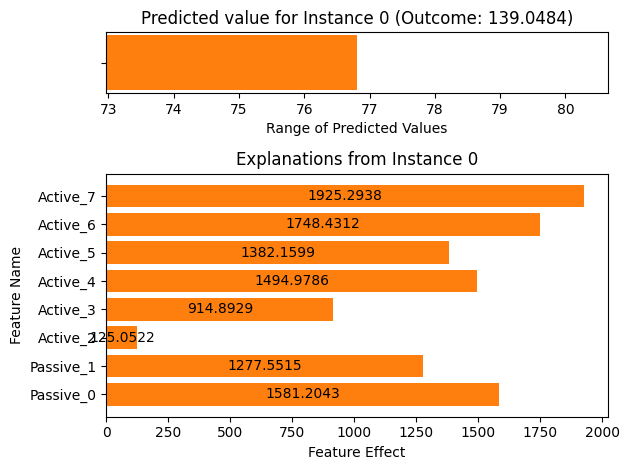

In [18]:
Reg_Stats.View_Explanation(instance = 0)

In [19]:
scores = URM_Exp.permutation_importance()
    


In [20]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[10.19368524 10.37229333 10.7965159  10.53587451 10.24937353 10.31599223
 10.07144597  9.91606095]


In [21]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[139.61528515 136.19211    128.91031835 133.25434485 138.52191192
 137.24544681 142.10612768 145.47578117]


In [22]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[0.39018139 1.54558234 0.08603989 0.04029673 1.55081501 1.40714022
 1.56574356 1.41420087]


In [23]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

[1.5147929  0.71597633 0.09467456 0.05325444 0.09467456 1.
 2.60946746 1.91715976]


In [24]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

Shapes:  (1, 8) (8,)
WS:  (21, 8)
W:   [[1.         1.         1.         1.         1.         1.
  1.         1.        ]
 [1.11620821 1.11620821 1.11620821 1.11620821 1.11620821 1.11620821
  1.11620821 1.11620821]
 [1.11505051 1.11505051 1.11505051 1.11505051 1.11505051 1.11505051
  1.11505051 1.11505051]
 [1.00130889 1.00130889 1.00130889 1.00130889 1.00130889 1.00130889
  1.00130889 1.00130889]
 [2.         2.         2.         2.         2.         2.
  2.         2.        ]
 [1.28304236 1.28304236 1.28304236 1.28304236 1.28304236 1.28304236
  1.28304236 1.28304236]
 [1.00612536 1.00612536 1.00612536 1.00612536 1.00612536 1.00612536
  1.00612536 1.00612536]
 [1.00904196 1.00904196 1.00904197 1.00904196 1.00904196 1.00904196
  1.00904196 1.00904196]
 [1.03094786 1.03094786 1.03094786 1.03094786 1.03094786 1.03094786
  1.03094786 1.03094786]
 [1.05520399 1.05520399 1.05520399 1.05520399 1.05520399 1.05520399
  1.05520399 1.05520399]
 [1.03637666 1.03637666 1.03637667 1.03637667 1

In [25]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.87689959e-01  9.82228323e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.89879392e-01  9.81690860e-01  1.51284846e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [26]:
acq_data.Create_BB_plot()

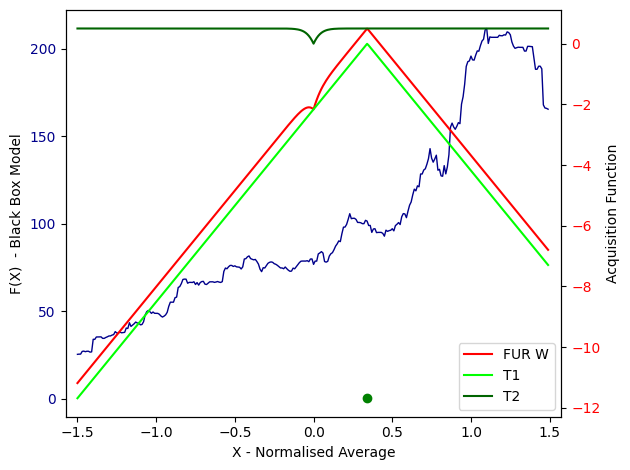

In [27]:
acq_data.plot_point(0)

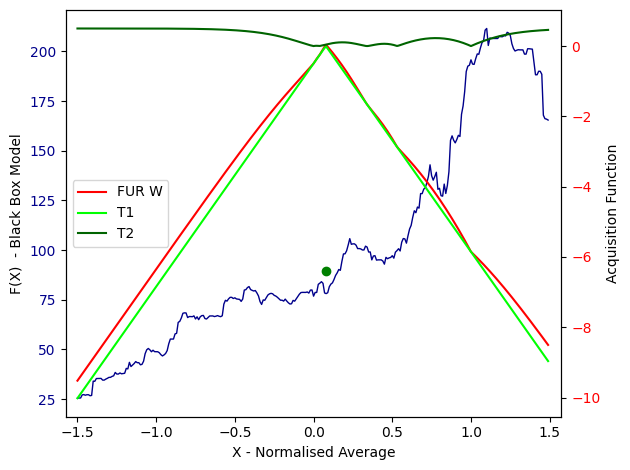

In [28]:
acq_data.plot_point(5)

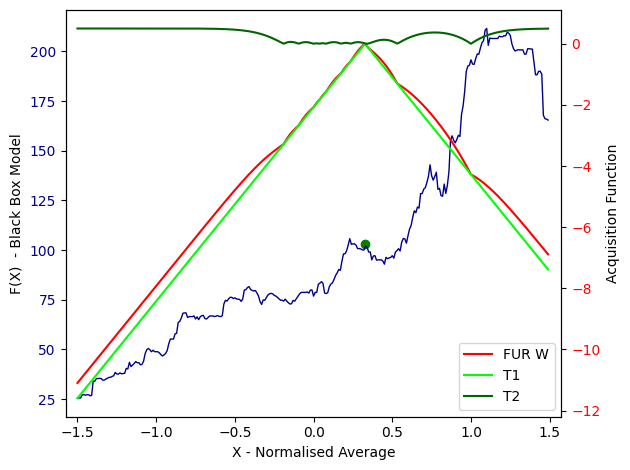

In [29]:
acq_data.plot_point(10)

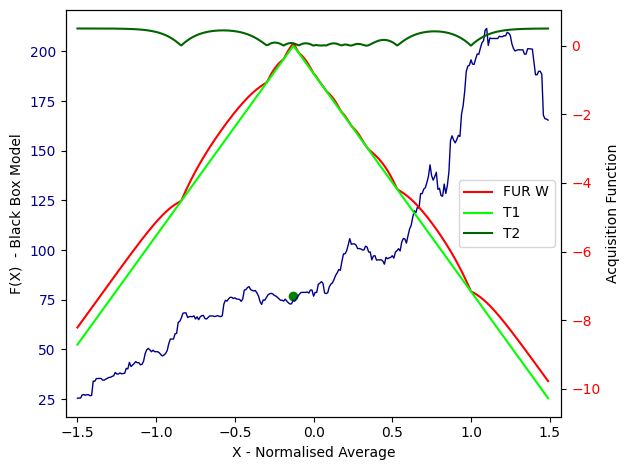

In [30]:
acq_data.plot_point(15)

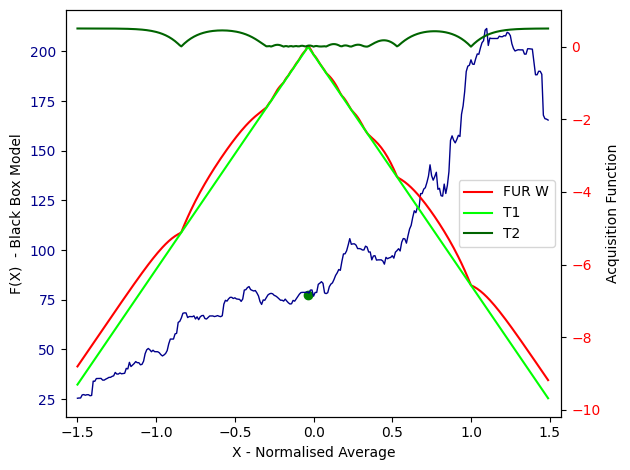

In [31]:
acq_data.plot_point(19)

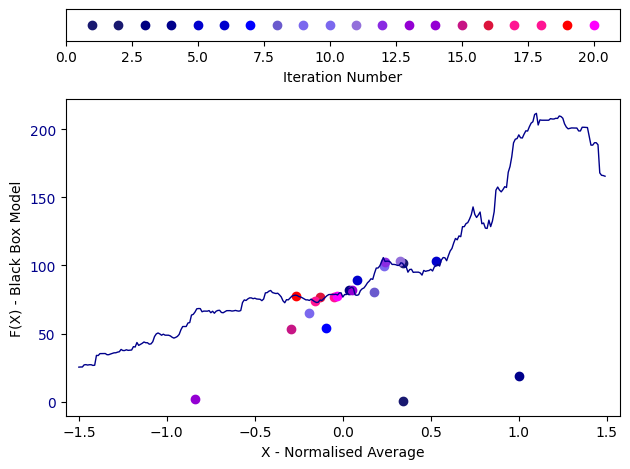

In [32]:
acq_data.plot_all()

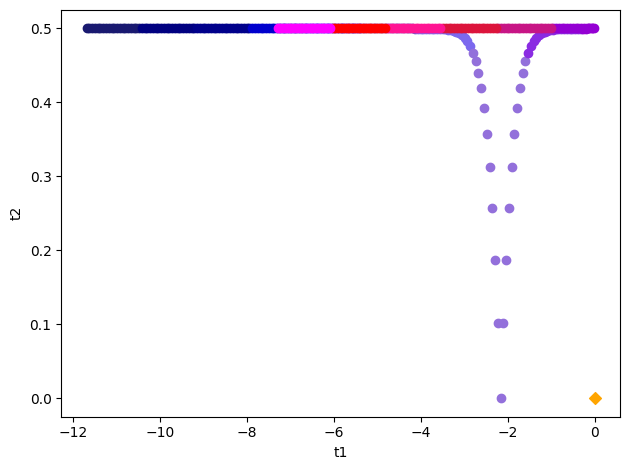

In [33]:
acq_data.plot_t1_t2(0)

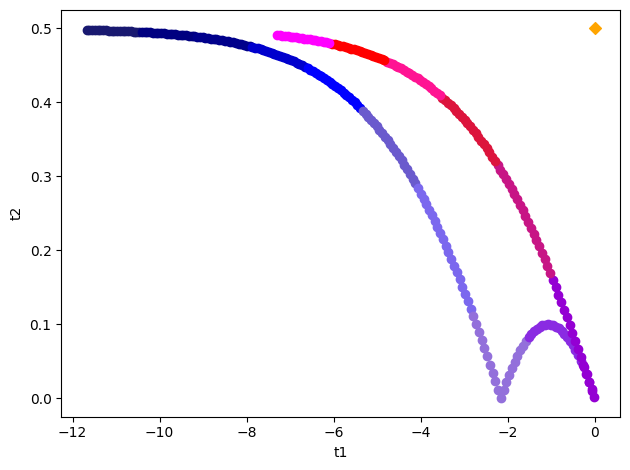

In [34]:
acq_data.plot_t1_t2(1)

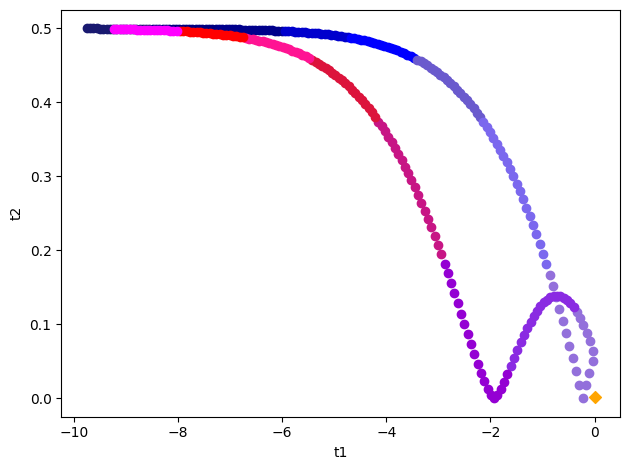

In [35]:
acq_data.plot_t1_t2(2)

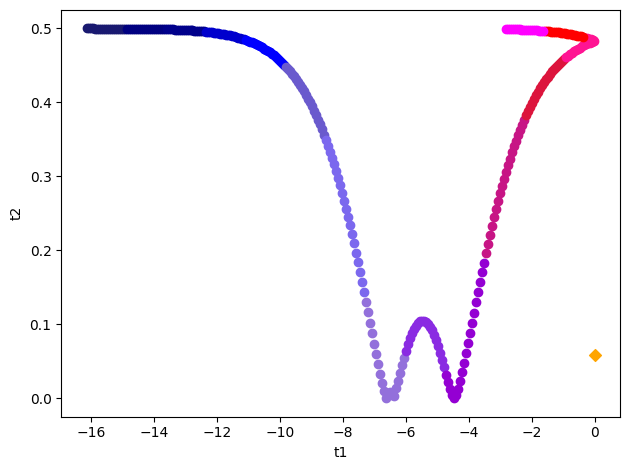

In [36]:
acq_data.plot_t1_t2(3)

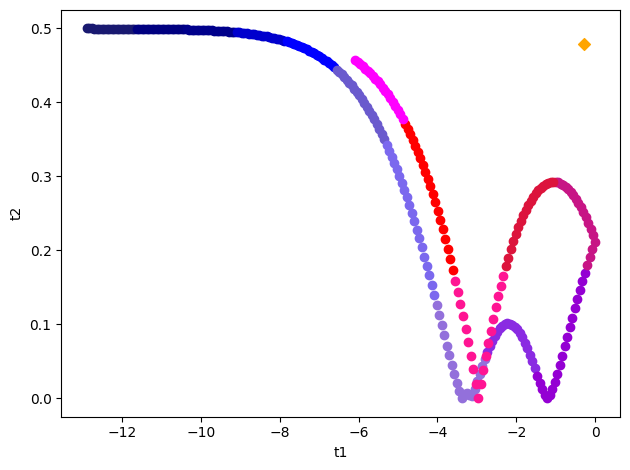

In [37]:
acq_data.plot_t1_t2(4)

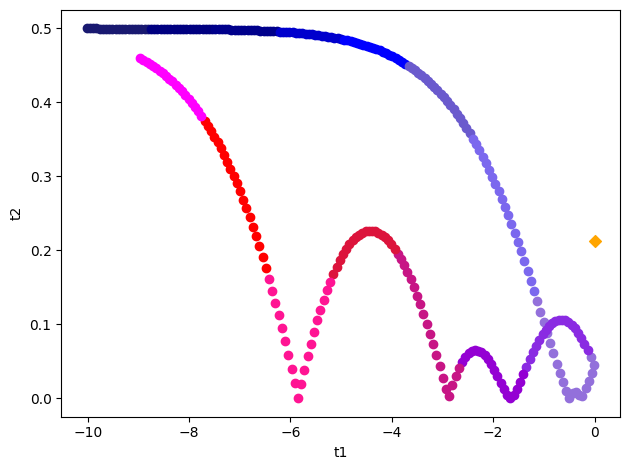

In [38]:
acq_data.plot_t1_t2(5)

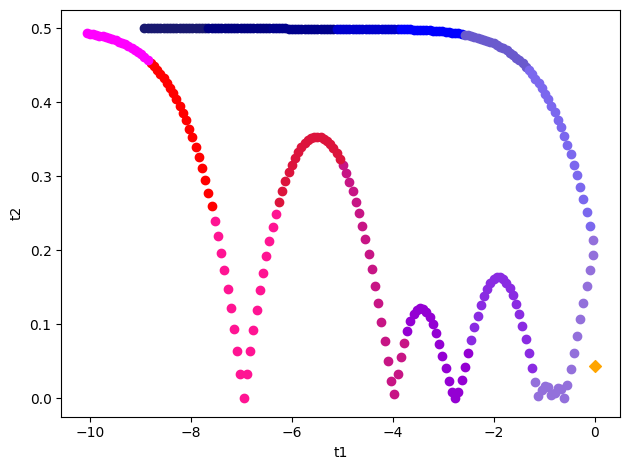

In [39]:
acq_data.plot_t1_t2(6)

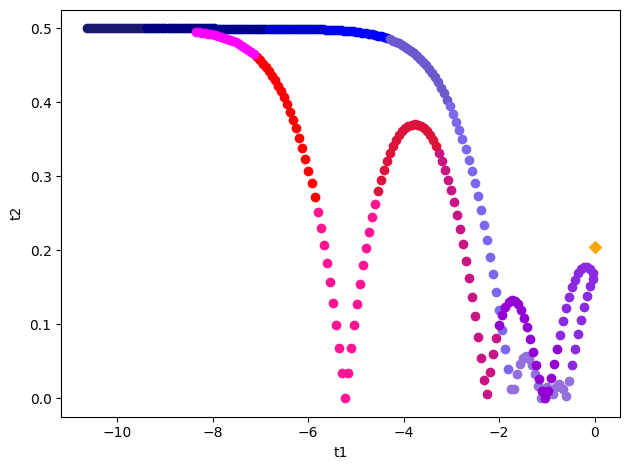

In [40]:
acq_data.plot_t1_t2(7)

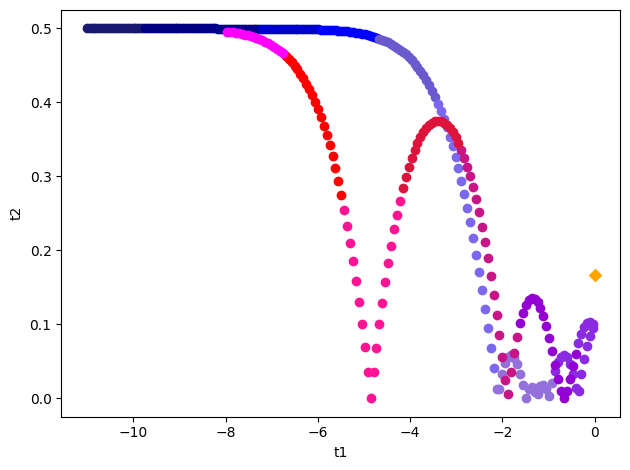

In [41]:
acq_data.plot_t1_t2(8)

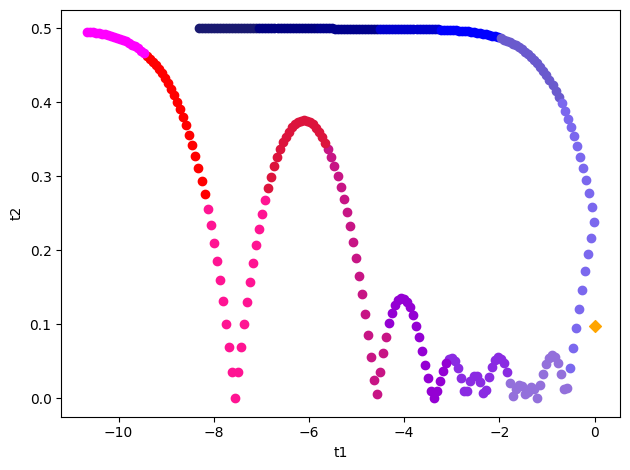

In [42]:
acq_data.plot_t1_t2(9)

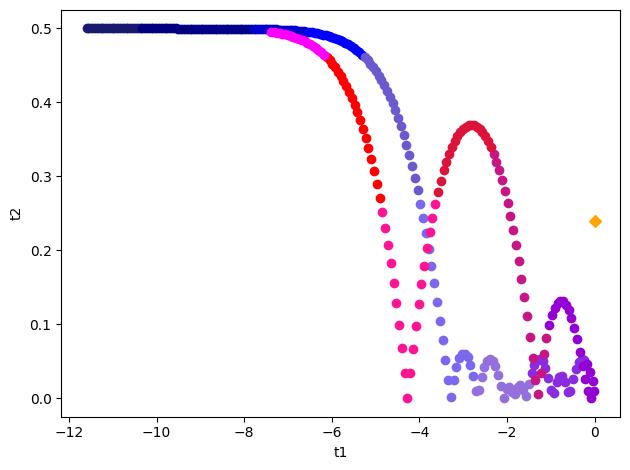

In [43]:
acq_data.plot_t1_t2(10)

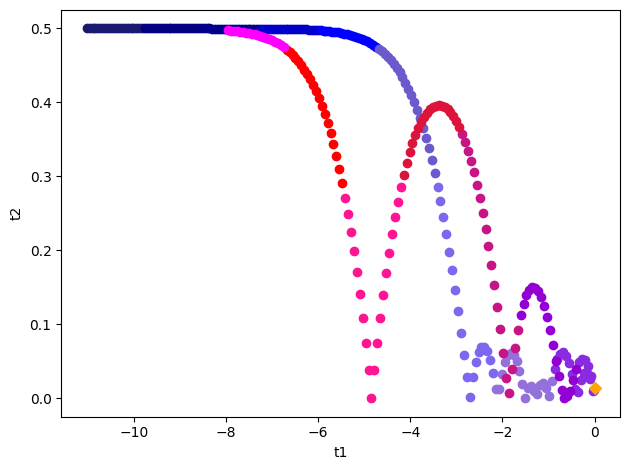

In [44]:
acq_data.plot_t1_t2(11)

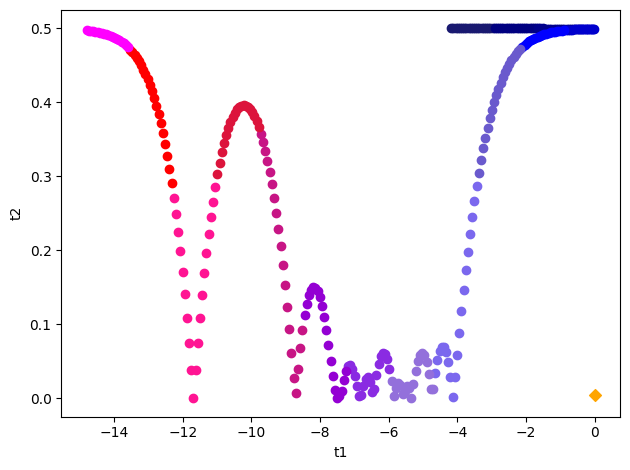

In [45]:
acq_data.plot_t1_t2(12)

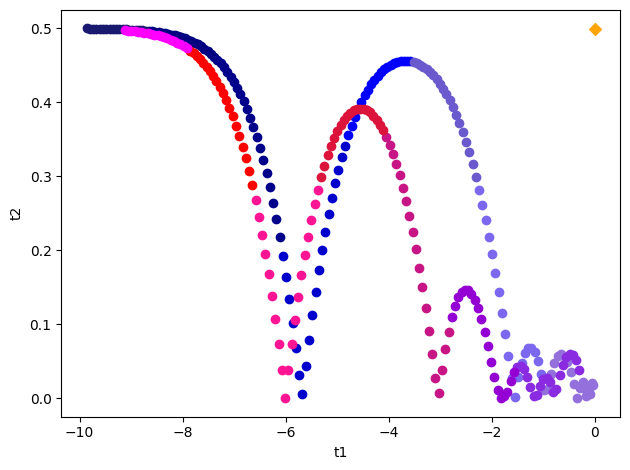

In [46]:
acq_data.plot_t1_t2(13)

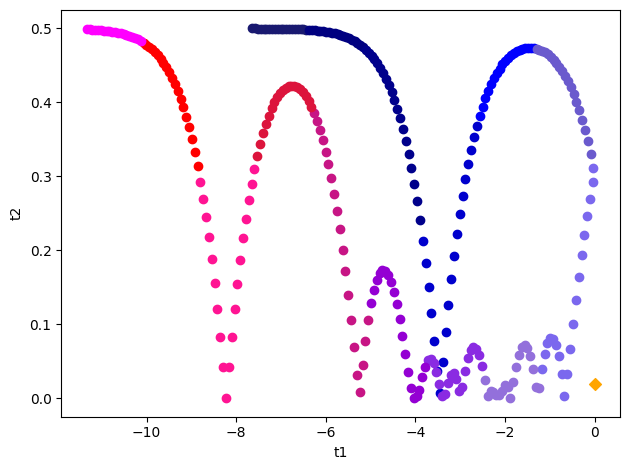

In [47]:
acq_data.plot_t1_t2(14)

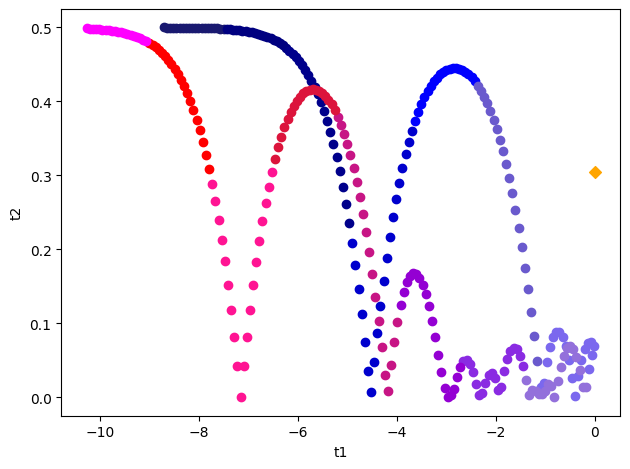

In [48]:
acq_data.plot_t1_t2(15)

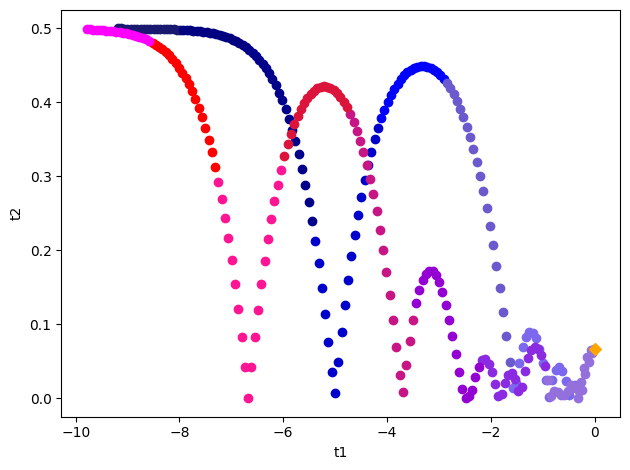

In [49]:
acq_data.plot_t1_t2(16)

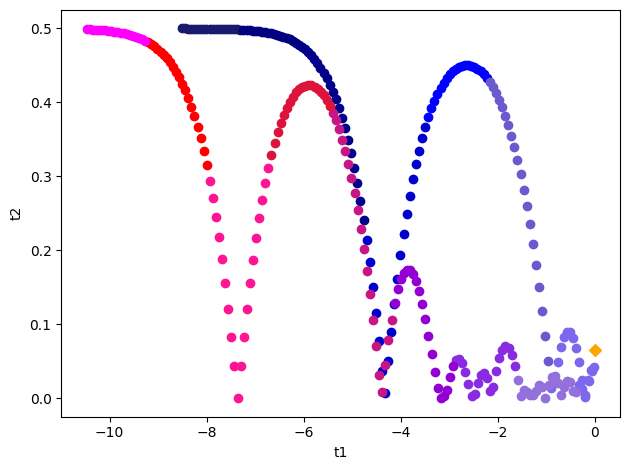

In [50]:
acq_data.plot_t1_t2(17)

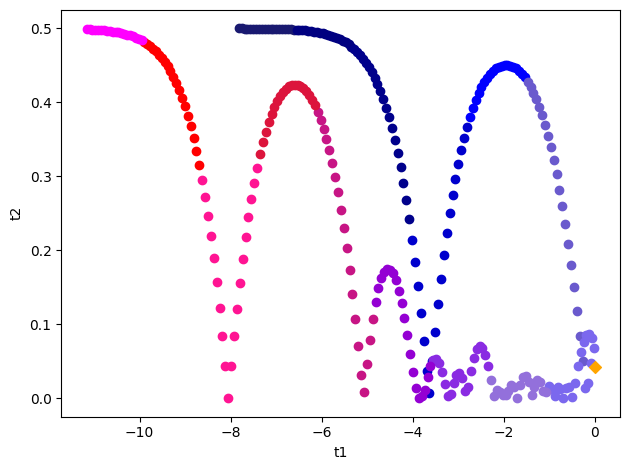

In [51]:
acq_data.plot_t1_t2(18)

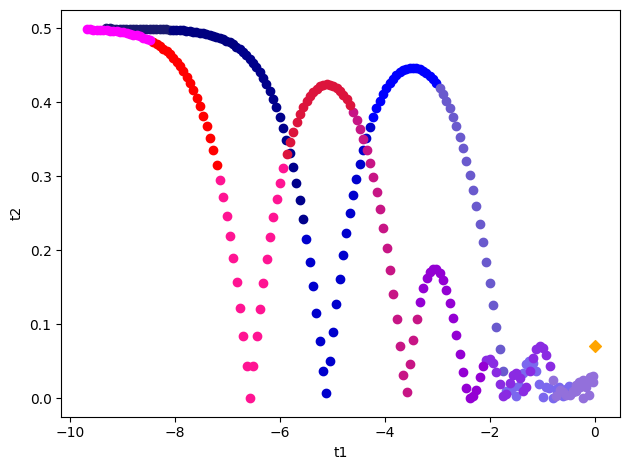

In [52]:
acq_data.plot_t1_t2(19)